# Monte Carlo Methods Exercises

**NOTICE:**
1. You are allowed to work in groups of up to three people but **have to document** your group's\
 members in the top cell of your notebook.
2. **Comment your code**, explain what you do (refer to the slides). It will help you understand the topics\
 and help me understand your thinking progress. Quality of comments will be graded.
3. **Discuss** and analyze your results, **write-down your learnings**. These exercises are no programming\
 exercises it is about learning and getting a touch for these methods. Such questions might be asked in the\
 final exams.
 4. Feel free to **experiment** with these methods. Change parameters think about improvements, write down\
 what you learned. This is not only about collecting points for the final grade, it is about understanding\
  the methods.

In [1]:
# If you run on google-colab you have to install this package whenever you start a kernel
!pip install gymnasium

### Exercise 1 - Blackjack (Monte Carlos ES)

**Summary:** In this exercise you will learn how to apply Monte Carlo ES to find the optimal strategy\
 playing the basic version of Blackjack. To do so you will implement the Monte Carlo (with exploring starts)\
  algorithm. This algorithm builds the basis for some variations we will talk about later in the lecture.\

  In Blackjack the Player plays versus the Dealer. The Dealer always follows the same algorithm. We can therefore\
  interpret the Dealer as part of the enivronment itself. See https://gymnasium.farama.org/environments/toy_text/blackjack/ \
  for more information about the exact game rules.


**Provided Code:** The cells below contains code to show you how to initialize the ```Blackjack-v1``` environment. See\
 https://gymnasium.farama.org/environments/toy_text/blackjack/ for more information about states, actions and\
 rewards.  Also provided is the ```test_policy()``` function which will help you compare the found policy by your implementation\
 with the mathematically optimal policy. The ```optimal_policy()``` is only used internally to compare policies\
 and is not required to solve the problem.



**Your Tasks in this exercise:**
1. Implement the Monte Carlo (ES) algorithm MC
    * Your implementation is only required to work for the ```Blackjack-v1``` environment
    * Your implementation should create a table (Q-Table) that contains the action-values for each state-action pair
    * You can use no discounted rewards (i.e.: $\gamma = 1.0$) for this example.
2. Test your Q-Table using the ```test_policy()``` function against the optimal policy.
    * The ```test_policy()``` will generate the greedy policy from your Q-Table (i.e.: pick the largest action under a state)
3. Answer and discuss the following questions:
    * Why is the exploring starts variation adequate for this environment? But not for the Frozen Lake environment we used before?
    * How can we speedup the implementation by improving on the pseudo code from the lecture?
    * Why can't we just use dynamic programming for this environment?
    * How many iterations does the algorithm require to find an approximately close policy to the optimal policy?

    

In [2]:
#@title **Provided Code:** ``optimal_policy()`` and ``test_policy()`` function.
import numpy as np

def optimal_policy(player, dealer, usable_ace):
    stick = 0
    hit = 1
    # Odds of the optimal policy are: Winning = 42.44%, Draw: 8.48%, Loss=49.10%

    if player < 12:
        return hit

    if usable_ace == 0:
        if dealer == 1 and player <= 16:
            return hit
        if (dealer == 2 or dealer == 3) and player == 12:
            return hit
        if (dealer >= 7 and dealer <= 9) and player <= 16:
            return hit
        if dealer == 10 and player <= 15:
            return hit
        return stick

    if usable_ace == 1:
        if player <= 17:
            return hit
        if (dealer == 1 or dealer == 9 or dealer == 10) and (player == 18):
            return hit
        return stick

def test_policy(env, Q, iterations=5000):
    '''
        Tests a policy.
        env - FrozenLake-v1 environment.
        pi - A policy (i.e. a numpy.ndarray such that pi[state] = action).
    '''
    wins_q = 0
    draws_q = 0
    losses_q = 0

    wins_o = 0
    draws_o = 0
    losses_o = 0

    for it in range(iterations):
        seed = np.random.randint(0, 100000)

        s,_ = env.reset(seed=seed)
        while True:
            a = int(np.argmax(Q[s[0], s[1], s[2], :]))
            s,reward,terminated,truncated,_ = env.step(a)

            if terminated == True or truncated == True:
                if int(reward) == 1:
                    wins_q += 1
                if int(reward) == -1:
                    losses_q +=1
                if int(reward) == 0:
                    draws_q += 1
                break

        s,_ = env.reset(seed=seed)
        while True:
            player = s[0]
            dealer = s[1]
            usable_ace = s[2]

            a = optimal_policy(player, dealer, usable_ace)
            s,reward,terminated,truncated,_ = env.step(a)

            if terminated == True or truncated == True:
                if int(reward) == 1:
                    wins_o += 1
                if int(reward) == -1:
                    losses_o +=1
                if int(reward) == 0:
                    draws_o += 1
                break

    print("Supplied Policy following Q -> Wins: %f, Draws: %f, Losses: %f" % (wins_q / iterations,draws_q/ iterations,losses_q/ iterations))
    print("Basic Policy (mathematically optimal without counting cards) -> Wins: %f, Draws: %f, Losses: %f" % (wins_o/ iterations,draws_o/ iterations,losses_o/ iterations))

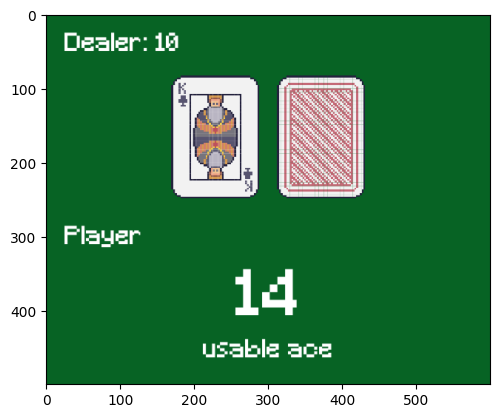

In [3]:
# Code to initialize the Environment.
#
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make('Blackjack-v1', sab=True, render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [12]:
from collections import defaultdict

def mc(env, n_episodes, gamma):
    # initialize action-values, 32 player sums, 11 dealer cards, 2 usable ace states, 2 actions
    Q = np.zeros((32, 11, 2, 2))

    # create table for returns
    returns = defaultdict(list) # automatically use an empty list for new keys

    # create policy with all zeros
    pi = np.zeros((32, 11, 2), dtype=int)

    for episode in range(n_episodes):
        # we reset, so we get a random start for exploring start
        s, _ = env.reset()
        # take a random action for exploring start
        a = np.random.randint(2)

        episode_sa = []
        episode_rewards = []

        # do a step in the environment and get next state, reward and info if we are done
        s_next, r, terminated, truncated, _ = env.step(a)
        episode_sa.append((s, a))
        episode_rewards.append(r)

        # continue with next state
        s = s_next

        # we run until the game is over
        while not (terminated or truncated):
            # extract player state, dealer state and usable ace
            player, dealer, usable = s
            # get action from policy
            a = pi[player, dealer, usable]

            # take step in environment
            s_next, r, terminated, truncated, _ = env.step(a)
            
            # keep track of state-action and reward
            episode_sa.append((s, a))
            episode_rewards.append(r)

            # move to next state
            s = s_next

        # start with 0 return
        G = 0
        # keep track of what state-actions we have already visited
        visited = set()

        # loop over the episode in reverse to calculate returns
        for t in reversed(range(len(episode_sa))):
            # calculate return for timestep t
            G = gamma * G + episode_rewards[t]
            # get state and action at time t
            s_t, a_t = episode_sa[t]
            # create a custom key with player-hand, dealer-hand, usable--ace and action
            key = (s_t[0], s_t[1], s_t[2], a_t)

            # check if we have not already visited - first-visit MC
            if key not in visited:
                # mark as visited
                visited.add(key)

                # add return to sum and increment count
                returns[key].append(G)
                Q[key] = np.mean(returns[key])

                # lets get the best action for this state
                pi[s_t[0], s_t[1], s_t[2]] = np.argmax(Q[s_t[0], s_t[1], s_t[2], :])

    return pi, Q

In [18]:
# get pi and Q for the environment with mc
pi, Q = mc(env, n_episodes=20000, gamma=1)

In [ ]:
# test the policy learned
test_policy(env, Q=Q)

Supplied Policy following Q -> Wins: 0.433000, Draws: 0.084800, Losses: 0.482200
Basic Policy (mathematically optimal without counting cards) -> Wins: 0.437800, Draws: 0.089400, Losses: 0.472800


In [23]:
different_number_of_episodes = [10, 50, 100, 1000, 5000, 10000, 50000, 100000]

for n_episodes in different_number_of_episodes:
    print(f"\nNumber of Episodes: {n_episodes}")
    pi, Q = mc(env, n_episodes=n_episodes, gamma=1)
    test_policy(env, Q=Q)



Number of Episodes: 10
Supplied Policy following Q -> Wins: 0.368200, Draws: 0.048600, Losses: 0.583200
Basic Policy (mathematically optimal without counting cards) -> Wins: 0.433600, Draws: 0.084400, Losses: 0.482000

Number of Episodes: 50
Supplied Policy following Q -> Wins: 0.378200, Draws: 0.054200, Losses: 0.567600
Basic Policy (mathematically optimal without counting cards) -> Wins: 0.437800, Draws: 0.087400, Losses: 0.474800

Number of Episodes: 100
Supplied Policy following Q -> Wins: 0.363600, Draws: 0.054200, Losses: 0.582200
Basic Policy (mathematically optimal without counting cards) -> Wins: 0.427800, Draws: 0.089400, Losses: 0.482800

Number of Episodes: 1000
Supplied Policy following Q -> Wins: 0.391200, Draws: 0.065800, Losses: 0.543000
Basic Policy (mathematically optimal without counting cards) -> Wins: 0.436800, Draws: 0.082000, Losses: 0.481200

Number of Episodes: 5000
Supplied Policy following Q -> Wins: 0.414200, Draws: 0.083200, Losses: 0.502600
Basic Policy (

# Answers
3. Answer and discuss the following questions:
    * Why is the exploring starts variation adequate for this environment? But not for the Frozen Lake environment we used before?

    When we start with Blackjack, we get random cards, and the dealer gets random cards as well. Every reset will give us a randomized start on it's own. On the Frozen Lake environment, we have the same start-point every time. We would need to start from different tiles to get a exploring starts.

    * How can we speedup the implementation by improving on the pseudo code from the lecture?

    We could use the incremental update for the returns. So we would not need to maintain a list of returns for the Q-values and then need to average them, but do it instantly.

    * Why can't we just use dynamic programming for this environment?

    We do not have access to the environment's transition probabilities. We do not know the dynamics-function and therefore we can not do dynamic programming.

    * How many iterations does the algorithm require to find an approximately close policy to the optimal policy?

    I run test with different number of episodes on the top. At around 50000 iterations we seem to get pretty close to the optimal policies, but we can still improve.

### Exercise 2 - On-Policy first-visit MC Control


**Summary:** In this exercise you will adapt the Monte Carlo (ES) algorithm to use the ideas of the\
On-Policy first-visit MC Control instead. We will again use it to solve the ```FrozenLake-v1``` environment.


**Provided Code:** The cells below contains code to show you how to initialize the ```FrozenLake-v1``` environment.\
There will be two variations:
* ```lake_small``` - is a small without slipping
* ```lake_slippery``` - is a large environment with slipping

See https://gymnasium.farama.org/environments/toy_text/frozen_lake/ for more information about states, actions and\
 rewards.  

Also provided is the ```test_policy_lake()``` function which runs your policy multiple times and gives you the\
success rate of your policy. The ```run_and_visualize_policy_lake()``` function displays your policy using the\
environment.


**Your Tasks in this exercise:**
1. Implement the On-Policy first-visit MC Control algorithm
    * Adapt your implementation of the MC exploring start algorithm (they are quite similar)
    * **Hint:** To implement the $\epsilon$-soft policy simply generate a random value (drawn from a uniform distribution)\
    with a probability of $\epsilon$ select a random action and with a probability of $1-\epsilon$ select the greedy action
    of your current policy.  
    * You can assume that your implementation only needs to solve the ```FrozenLake-v1``` environment
    * To find the number of states you can use ```env.observation_space.n``` on the environment object
    * Your implementation should create a table (Q-Table) that contains the action-values for each state-action pair
    

2. Run your implementation to solve the ```lake_small``` environment
    * Execute the ```test_policy_lake()``` to find your success rate
3. Try to solve the ```lake_slippery``` environment  (note that this might not work)
    * Execute the ```test_policy_lake()``` to find your success rate

4. Analyze, discuss and answer the following questions:
    * Why is the exploring starts variation not adequate for this environment? But not for the Black Jack environment we used before?
    * Why is it easy to solve the ```lake_small``` but seems impossible to solve the ```lake_slippery``` environment?
    * Explain the differences to the Monte Carlo exploring starts algorithm




In [128]:
#@title **Provided Code:** ``run_and_visualize_policy_lake()`` and ``test_policy_lake()`` function.

from IPython import display
import time
def run_and_visualize_policy_lake(env, Q, delay=0.175):
    '''
        Visualizes a policy.
        env - FrozenLake-v1 environment.
        pi - A policy (i.e. a numpy.ndarray such that pi[state] = action).
    '''
    s, _ = env.reset()
    plt.imshow(env.render())

    while True:
        a = np.argmax(Q[s])
        s,_,terminated,truncated,_ = env.step(a)
        plt.imshow(env.render())
        plt.show()
        display.clear_output(wait=True)
        time.sleep(delay)

        if terminated or truncated:
            break

def test_policy_lake(env, Q, iterations=500):
    '''
        Tests a policy.
        env - FrozenLake-v1 environment.
        pi - A policy (i.e. a numpy.ndarray such that pi[state] = action).
    '''
    success_cnt = 0
    for it in range(iterations):
        s,_ = env.reset()
        while True:
            a = np.argmax(Q[s])
            s,reward,terminated,truncated,_ = env.step(a)

            if terminated == True or truncated == True:
                if int(reward) == 1:
                    success_cnt += 1
                break
    return 100 * (success_cnt / iterations)

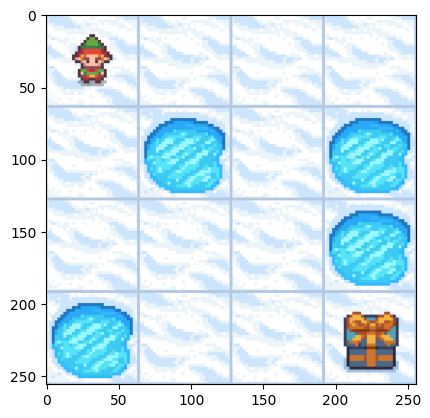

In [105]:
# This cell initializes the environment and the system dynamics object.
#
import matplotlib.pyplot as plt
import gymnasium as gym

lake_small = gym.make('FrozenLake-v1',  map_name="4x4", is_slippery=False, render_mode='rgb_array')

lake_slippery = gym.make('FrozenLake-v1', desc=['SFHFFFFF', 'FFHFFFFF', 'FFHFFHFF', 'FFHFFHFF','FFHFFHFF','FFHFFHFF','FFFFFHFF','FFFFFHFG'],
                        is_slippery=True, render_mode='rgb_array')
lake_slippery._max_episode_steps = 2000

lake_slippery.reset()
lake_small.reset()
plt.imshow(lake_small.render())

In [116]:
import numpy as np
from collections import defaultdict

def mc_on_policy(env, n_episodes, gamma, epsilon):
    # get number of states and actions
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # initilaize action-value table with ones, this will lead to high exploration while learning- values will be optimistic at start
    Q = np.ones((n_states, n_actions))

    # create dict for returns
    returns = defaultdict(list)

    successful_episodes = 0

    for episode in range(n_episodes):
        # Generate one episode
        episode_sa = []
        episode_rewards = []

        # start new episode
        s, _ = env.reset()

        # set terminated and truncated flags to false, we can not start in terminated state
        terminated = False
        truncated = False

        # continue until episode is done
        while not (terminated or truncated):
            # use epsilon to get random action sometimes
            if np.random.rand() < epsilon:
                a = np.random.randint(n_actions)
            else:
                a = np.argmax(Q[s]) # get greedy action

            # take step in environment
            s_next, r, terminated, truncated, _ = env.step(a)

            # keep track of state-action and reward
            episode_sa.append((s, a))
            episode_rewards.append(r)

            # move to next state
            s = s_next

        # when episode finished, start with return 0 and empty visited set
        G = 0
        visited = set()

        if episode_rewards[-1] == 1:
            successful_episodes += 1

        # loop over episode in reverse to calculate returns
        for t in reversed(range(len(episode_sa))):
            # calculate return for timestep t
            G = gamma * G + episode_rewards[t]
            # get state and action at time t
            s_t, a_t = episode_sa[t]

            # check if first visit
            if (s_t, a_t) not in visited:
                # mark as visited
                visited.add((s_t, a_t))

                # add return to returns list
                returns[(s_t, a_t)].append(G)
                # update Q value as mean of returns
                Q[s_t, a_t] = np.mean(returns[(s_t, a_t)])
    print("Successful episodes:", successful_episodes, "out of", n_episodes)
    return Q

In [136]:
Q_small = mc_on_policy(lake_small, n_episodes=20000, epsilon=0.1, gamma=1)
print("Small lake success rate:", test_policy_lake(lake_small, Q_small))

Successful episodes: 15660 out of 20000
Small lake success rate: 100.0


In [137]:
Q_slip = mc_on_policy(lake_slippery, n_episodes=10000, epsilon=0.01, gamma=1)
print("Slippery lake success rate:", test_policy_lake(lake_slippery, Q_slip))

Successful episodes: 0 out of 10000
Slippery lake success rate: 0.0


# Answers

4. Analyze, discuss and answer the following questions:
    * Why is the exploring starts variation not adequate for this environment? But not for the Black Jack environment we used before?

    Exploring Starts can be done, if we can start an episode from any (state-action)-pair. On Blackjack it is possible, since the initial hands are random. On the FrozenLake i always start on the same tile, the start tile. i can not tell the environment to just teleport me to a random tile.

    * Why is it easy to solve the ```lake_small``` but seems impossible to solve the ```lake_slippery``` environment?

    On the lake_slippery, a lot of the episode fails and i will not have any return for these episodes. The learning signals are very weak. Also having a high epsilon leads to falling into holes very fast. On the small lake, we will get to the goal way more often, therefore the reward signal is stronger.
    Most of the time when we once found a successful episodes, we pick up learning faster.


    * Explain the differences to the Monte Carlo exploring starts algorithm

    For the Exploring Starts, we start at a random place and take a random action. But after that we always follow the greedy policy. On the On-Policy we start at a fixed place. To explore we use the e-soft-policy, so we depend on the policy to sometimes try to explore new action. 

## Deleted Importance sampling exercise